In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
from pseudo_arclength import *  # Local file, for multiple solutions

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
from Models import *
from Models.FENE import *

In [4]:
ndim = 3  # Spatial dimensions

In [5]:
from scipy.integrate import RK45, Radau, LSODA, odeint

In [6]:
def oscillatory_shear(Wi, constEq, dγdt, t, con_kwargs={}):
    """Oscillatory shear for different constitutive models.

    Can be used for small amplitude oscillatory shear (SAOS), large amplitude
    oscillatory shear (LAOS), or chirp rheology.

    Parameters
    ----------
    Wi : float
        Wi-value, corresponding to relaxation time here.
    constEq : ConstitutiveModel
        Static class for constitutive model.
    dγdt : lambda(t)
        Shear rate function driving the flow.
    t : numpy.array
        Time sequence of solution.
    con_kwargs : dict
        Parameters for constitutive model.

    Returns
    -------
    t : narray
        Array of time steps.
    τ : narray
        Array of (polymeric and viscous) stress tensors.
    """
    # Gradient for different shear flows (non-dimensional)
    gradU = np.array([[0.0, 0.0, 0.0],
                      [1.0, 0.0, 0.0],
                      [0.0, 0.0, 0.0]])
    # Initial values
    A0 = constEq.zero_state(ndim)
    # RHS
    rhs = lambda t, A: -constEq.equation(A, gradU*dγdt(t), Wi, **con_kwargs)
    adj_rhs = lambda A, t: rhs(t, A.reshape(A0.shape)).flatten()
    # Run ODE
    Avals = odeint(adj_rhs, A0.flatten(), t)

    # Transform output
    nSteps = len(t)
    τ = np.empty((nSteps, ndim, ndim))
    for idx in range(nSteps):
        A = Avals[idx].reshape(A0.shape)
        τ[idx] = constEq.stress_tensor(A, gradU*dγdt(t[idx]), Wi, **con_kwargs)
    return τ

## Small Amplitude Oscillatory Shear (SAOS)

In [7]:
γ0 = 1.0  # Amplitude
ωs = np.logspace(-3,5,100)
models = [
    Oldroyd_B.Oldroyd_B,
    FENE_CR.FENE_CR,
    FENE_P.FENE_P,
    Johnson_Segalman.Johnson_Segalman,
    Giesekus.Giesekus,
]
model_parameters = [
    {"β":0.0},
    {"β":0.0, "L":100},
    {"β":0.0, "L":100},
    {"β":0.0, "ε0":0.1},
    {"β":0.0, "α":0.1},
]

In [8]:
res_saos = []  # Result of every model requested
for idx, model in enumerate(models):
    Gs = np.empty(ωs.shape)
    Gl = np.empty(ωs.shape)

    for jdx, ω in enumerate(ωs):
        γ = lambda t: γ0*np.sin(ω*t)
        dγdt = lambda t: ω*γ0*np.cos(ω*t)

        # NOTE: Required to exclude endpoint for periodic function
        # NOTE: Some error from startup, but small
        t, dt = np.linspace(0, 2*np.pi*16/ω, 256, endpoint=False, retstep=True)
        # Relaxation time set to 1.0 (using Weissenberg number)
        τ = oscillatory_shear(1.0, model, dγdt, t, model_parameters[idx])

        # Fourier transform
        τh = fft.rfft(τ[:,0,1])
        freq = 2*np.pi*fft.rfftfreq(len(t), dt)
        ωdx = np.argmin(np.abs((freq-ω)**2))

        # Storage and loss modulus
        Gs[jdx] = -τh[ωdx].imag / (γ0*len(τh))
        Gl[jdx] = τh[ωdx].real / (γ0*len(τh))

    res_saos.append((Gs, Gl))

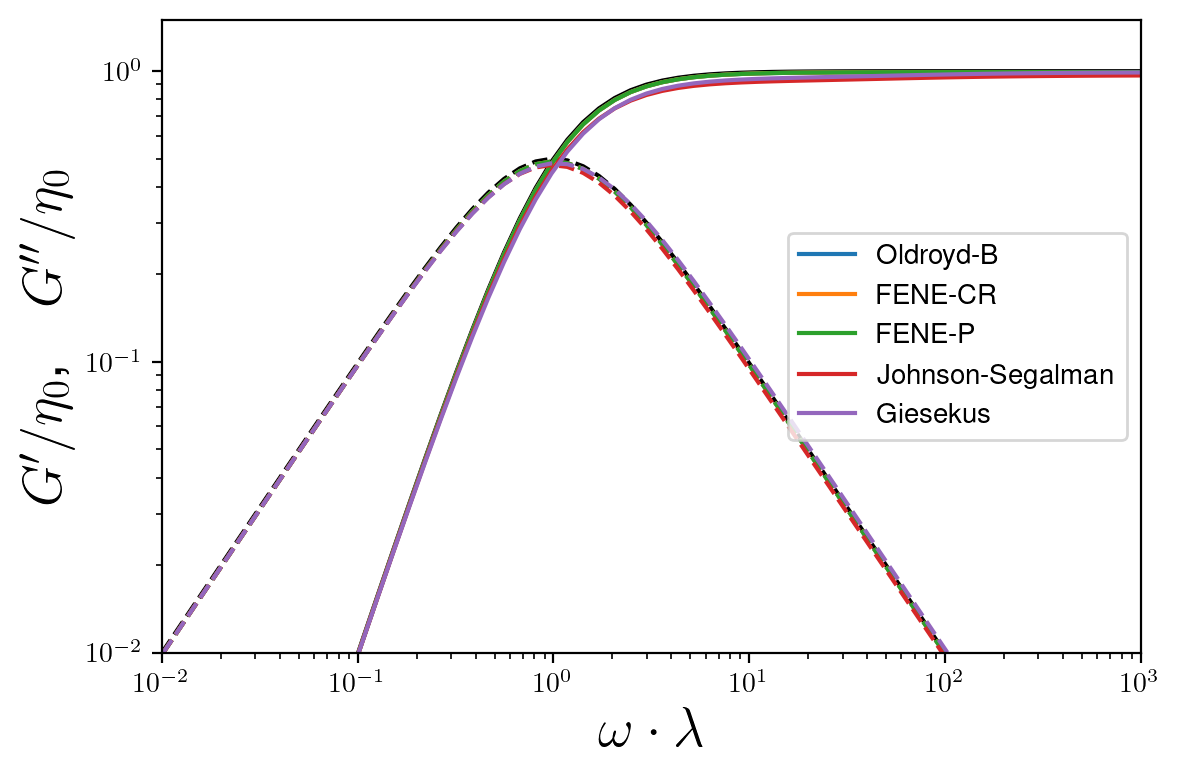

In [9]:
fig, axis = plt.subplots(1, 1, figsize=(6,4))

# Maxwell Model reference (zero viscosity)
axis.plot(ωs, ωs**2/(1+ωs**2), "-k")
axis.plot(ωs, ωs/(1+ωs**2), "--k")

for idx, model in enumerate(models):
    Gs, Gl = res_saos[idx]
    color = axis._get_lines.get_next_color()
    axis.plot(ωs, Gs, '-', color=color, label=model.name)
    axis.plot(ωs, Gl, '--', color=color)

axis.set_ylabel("$G' / \\eta_0$,\\quad $G'' / \\eta_0$", size=20)
axis.set_xlabel("$\\omega \\cdot \\lambda$", size=20)
axis.set_xscale("log")
axis.set_yscale("log")
axis.set_xlim([1e-2, 1e3])
axis.set_ylim([1e-2, 1.5])
axis.legend()
plt.tight_layout()
plt.show()

## Large Amplitude Oscillatory Shear (LAOS)
TODO
- Odd and even decomposition (reversible (elastic) vs irreversible (viscous) parts)
- Chebyshev decomposition? (modes for the two parts above)

In [10]:
Wis = [0.1, 1.0, 10.0]  # Wi = Frequency * Amplitude * Relaxation Time
Des = [0.1, 1.0, 10.0]  # De = Frequency * Relaxation Time

models = [
    Oldroyd_B.Oldroyd_B,
    Oldroyd_A.Oldroyd_A,
    FENE_P.FENE_P,
    Giesekus.Giesekus,
]
model_parameters = [
    {"β":0.0},
    {"β":0.0},
    {"β":0.0, "L":100},
    {"β":0.0, "α":0.1},
]

In [11]:
res_laos = []  # Result of every model requested
for idx, model in enumerate(models):
    res_laos.append([])
    for jdx, Wi in enumerate(Wis):
        res_laos[idx].append([])
        for kdx, De in enumerate(Des):
            γ = lambda t: Wi/De*np.sin(De*t)
            dγdt = lambda t: Wi*np.cos(De*t)
            t, dt = np.linspace(0, 2*np.pi*8/De, 2048, endpoint=False, retstep=True)
            # Relaxation time set to 1.0 (using Weissenberg number)
            τ = oscillatory_shear(1.0, model, dγdt, t, model_parameters[idx])
            res_laos[idx][jdx].append((t, τ))

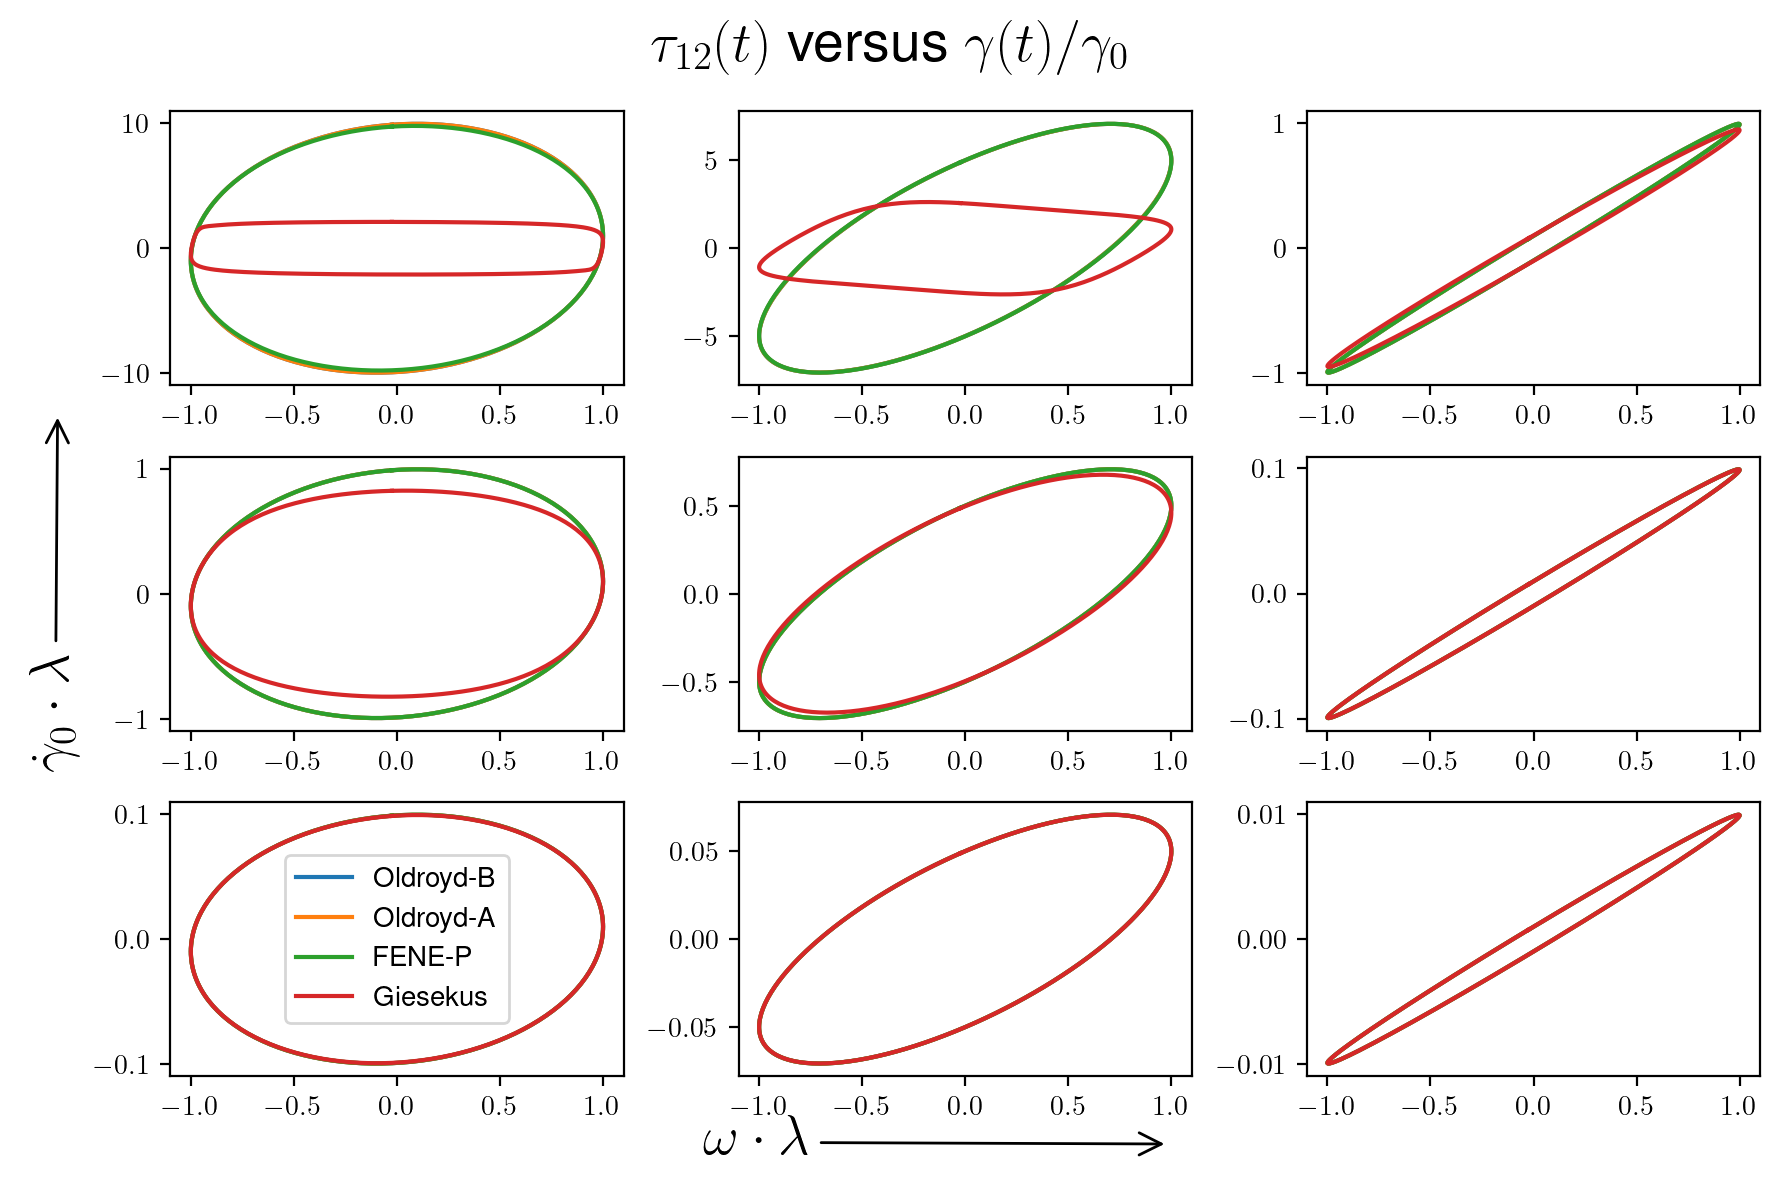

In [12]:
fig, axes = plt.subplots(len(Wis), len(Des), figsize=(3*len(Des),2*len(Wis)))
for jdx, Wi in enumerate(Wis):
    for kdx, De in enumerate(Des):
        γ = lambda t: Wi/De*np.sin(De*t)
        dγdt = lambda t: Wi*np.cos(De*t)
        for idx, model in enumerate(models):
            t, τ = res_laos[idx][jdx][kdx]
            axes[len(Wis)-1-jdx,kdx].plot(γ(t[-257:])/ (Wi/De), τ[:,0,1][-257:], label=model.name)

axes[-1,0].legend()
plt.suptitle("$\\tau_{12}(t)$ versus $\\gamma(t) / \\gamma_0$", size=20)

plt.tight_layout()
fig.subplots_adjust(left=0.1)
fig.subplots_adjust(bottom=0.1)
plt.annotate("$\\dot{\\gamma}_0 \\cdot \\lambda$", fontsize=20,
    xy=(0.032, 0.65), xytext=(0.045, 0.35), xycoords='figure fraction',
    arrowprops=dict(arrowstyle="->"), ha='right', va='bottom', rotation=90
)
plt.annotate("$\\omega \\cdot \\lambda$", fontsize=20,
    xy=(0.65, 0.04), xytext=(0.45, 0.02), xycoords='figure fraction',
    arrowprops=dict(arrowstyle="->"), ha='right', va='bottom', rotation=0
)

plt.show()

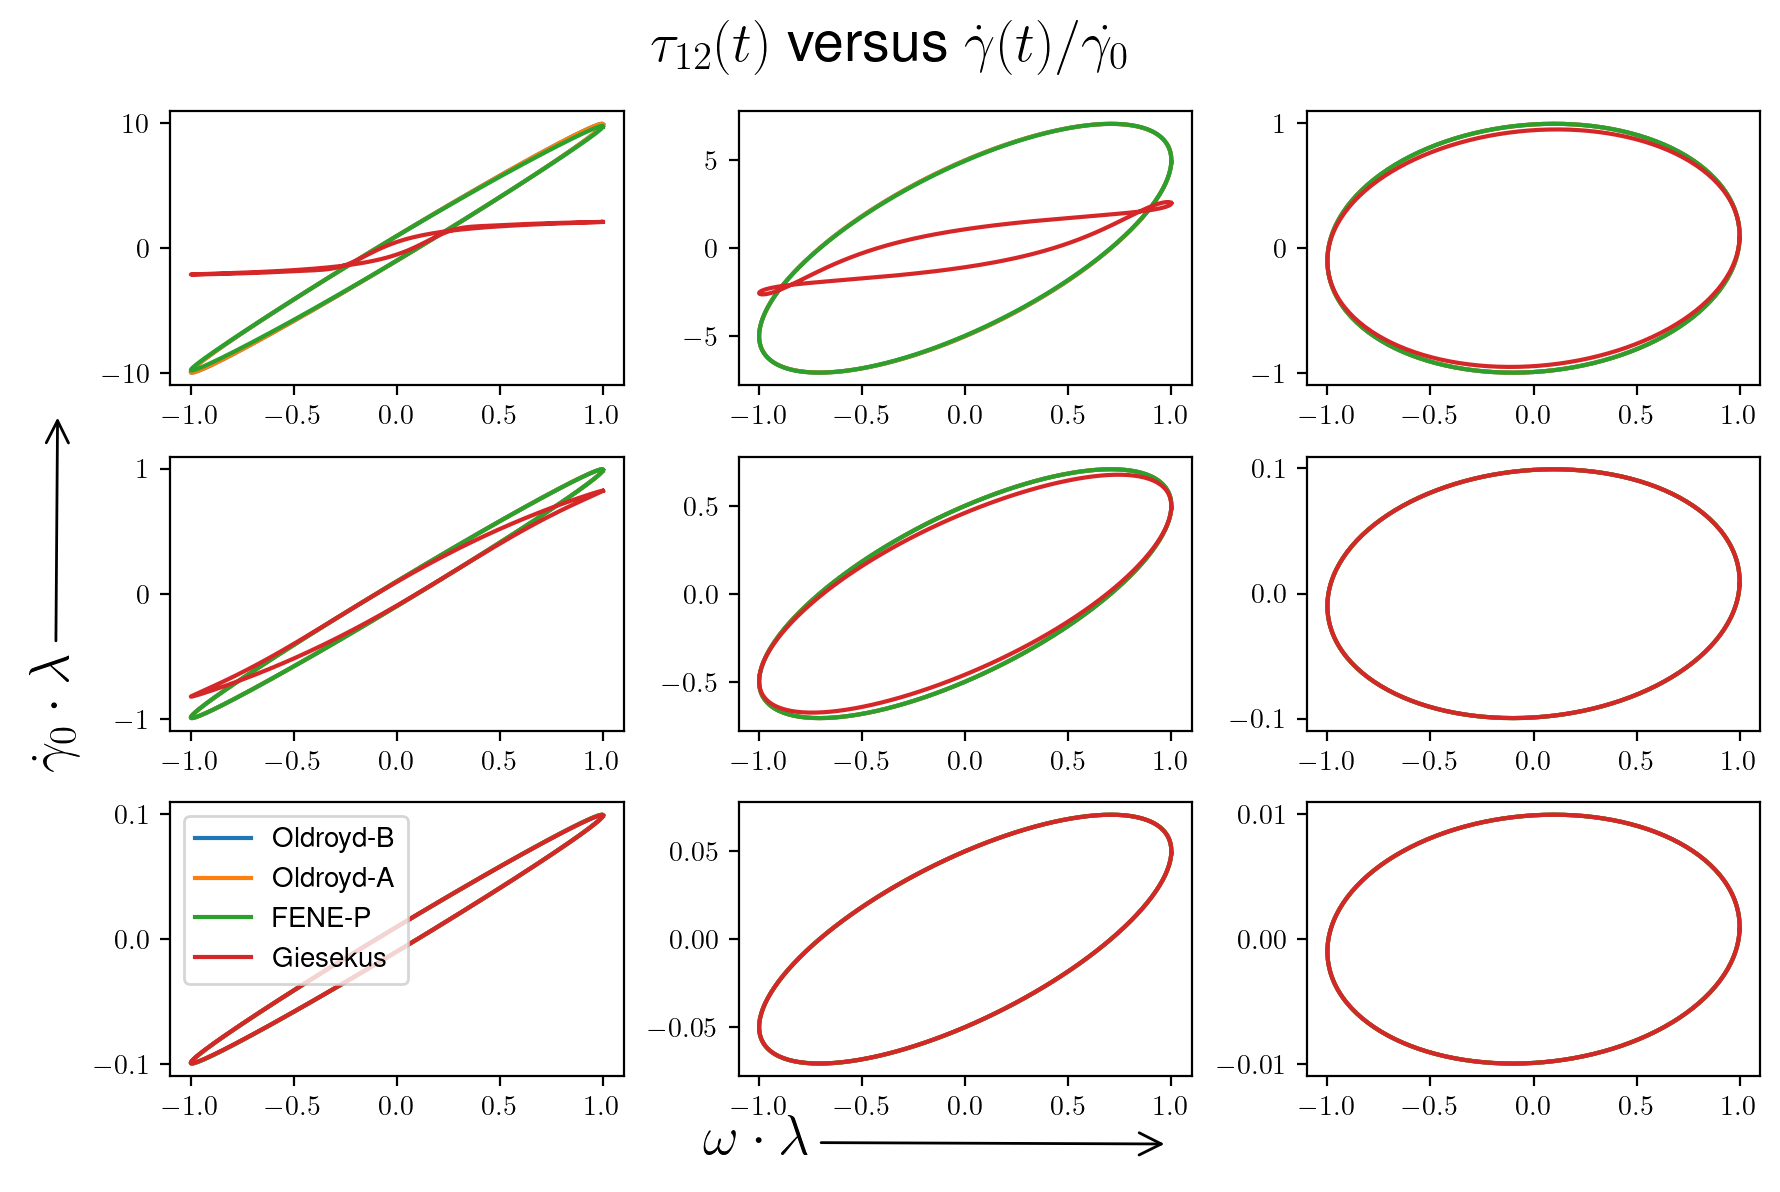

In [13]:
fig, axes = plt.subplots(len(Wis), len(Des), figsize=(3*len(Des),2*len(Wis)))
for jdx, Wi in enumerate(Wis):
    for kdx, De in enumerate(Des):
        γ = lambda t: Wi/De*np.sin(De*t)
        dγdt = lambda t: Wi*np.cos(De*t)
        for idx, model in enumerate(models):
            t, τ = res_laos[idx][jdx][kdx]
            axes[len(Wis)-1-jdx,kdx].plot(dγdt(t[-257:])/ Wi, τ[:,0,1][-257:], label=model.name)

axes[-1,0].legend()
plt.suptitle("$\\tau_{12}(t)$ versus $\\dot{\\gamma}(t) / \\dot{\\gamma_0}$", size=20)

plt.tight_layout()
fig.subplots_adjust(left=0.1)
fig.subplots_adjust(bottom=0.1)
plt.annotate("$\\dot{\\gamma}_0 \\cdot \\lambda$", fontsize=20,
    xy=(0.032, 0.65), xytext=(0.045, 0.35), xycoords='figure fraction',
    arrowprops=dict(arrowstyle="->"), ha='right', va='bottom', rotation=90
)
plt.annotate("$\\omega \\cdot \\lambda$", fontsize=20,
    xy=(0.65, 0.04), xytext=(0.45, 0.02), xycoords='figure fraction',
    arrowprops=dict(arrowstyle="->"), ha='right', va='bottom', rotation=0
)

plt.show()

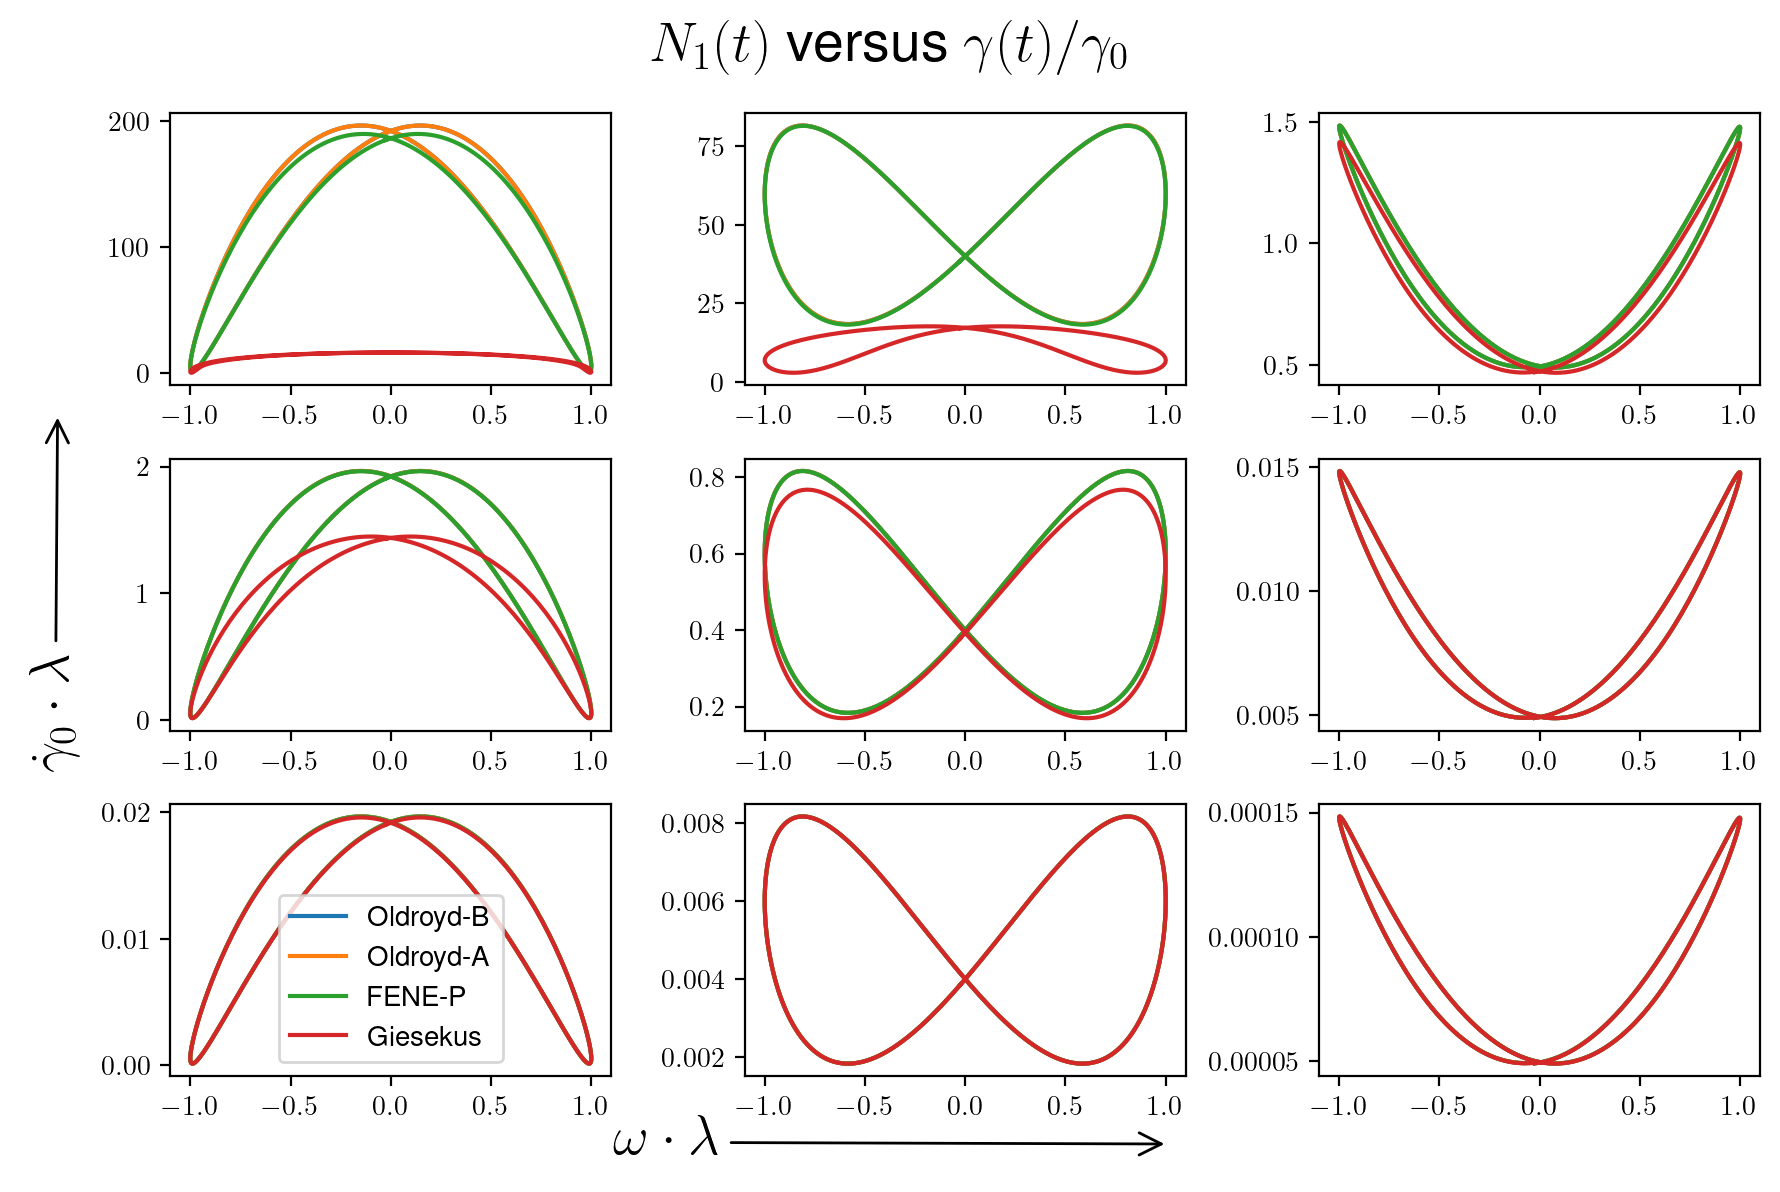

In [14]:
fig, axes = plt.subplots(len(Wis), len(Des), figsize=(3*len(Des),2*len(Wis)))
for jdx, Wi in enumerate(Wis):
    for kdx, De in enumerate(Des):
        γ = lambda t: Wi/De*np.sin(De*t)
        dγdt = lambda t: Wi*np.cos(De*t)
        for idx, model in enumerate(models):
            t, τ = res_laos[idx][jdx][kdx]
            axes[len(Wis)-1-jdx,kdx].plot(γ(t[-257:]) / (Wi/De), τ[:,0,0][-257:]-τ[:,1,1][-257:], label=model.name)

axes[-1,0].legend()
plt.suptitle("$N_1(t)$ versus $\\gamma(t) / \\gamma_0$", size=20)

plt.tight_layout()
fig.subplots_adjust(left=0.1)
fig.subplots_adjust(bottom=0.1)
plt.annotate("$\\dot{\\gamma}_0 \\cdot \\lambda$", fontsize=20,
    xy=(0.032, 0.65), xytext=(0.045, 0.35), xycoords='figure fraction',
    arrowprops=dict(arrowstyle="->"), ha='right', va='bottom', rotation=90
)
plt.annotate("$\\omega \\cdot \\lambda$", fontsize=20,
    xy=(0.65, 0.04), xytext=(0.4, 0.02), xycoords='figure fraction',
    arrowprops=dict(arrowstyle="->"), ha='right', va='bottom', rotation=0
)

plt.show()

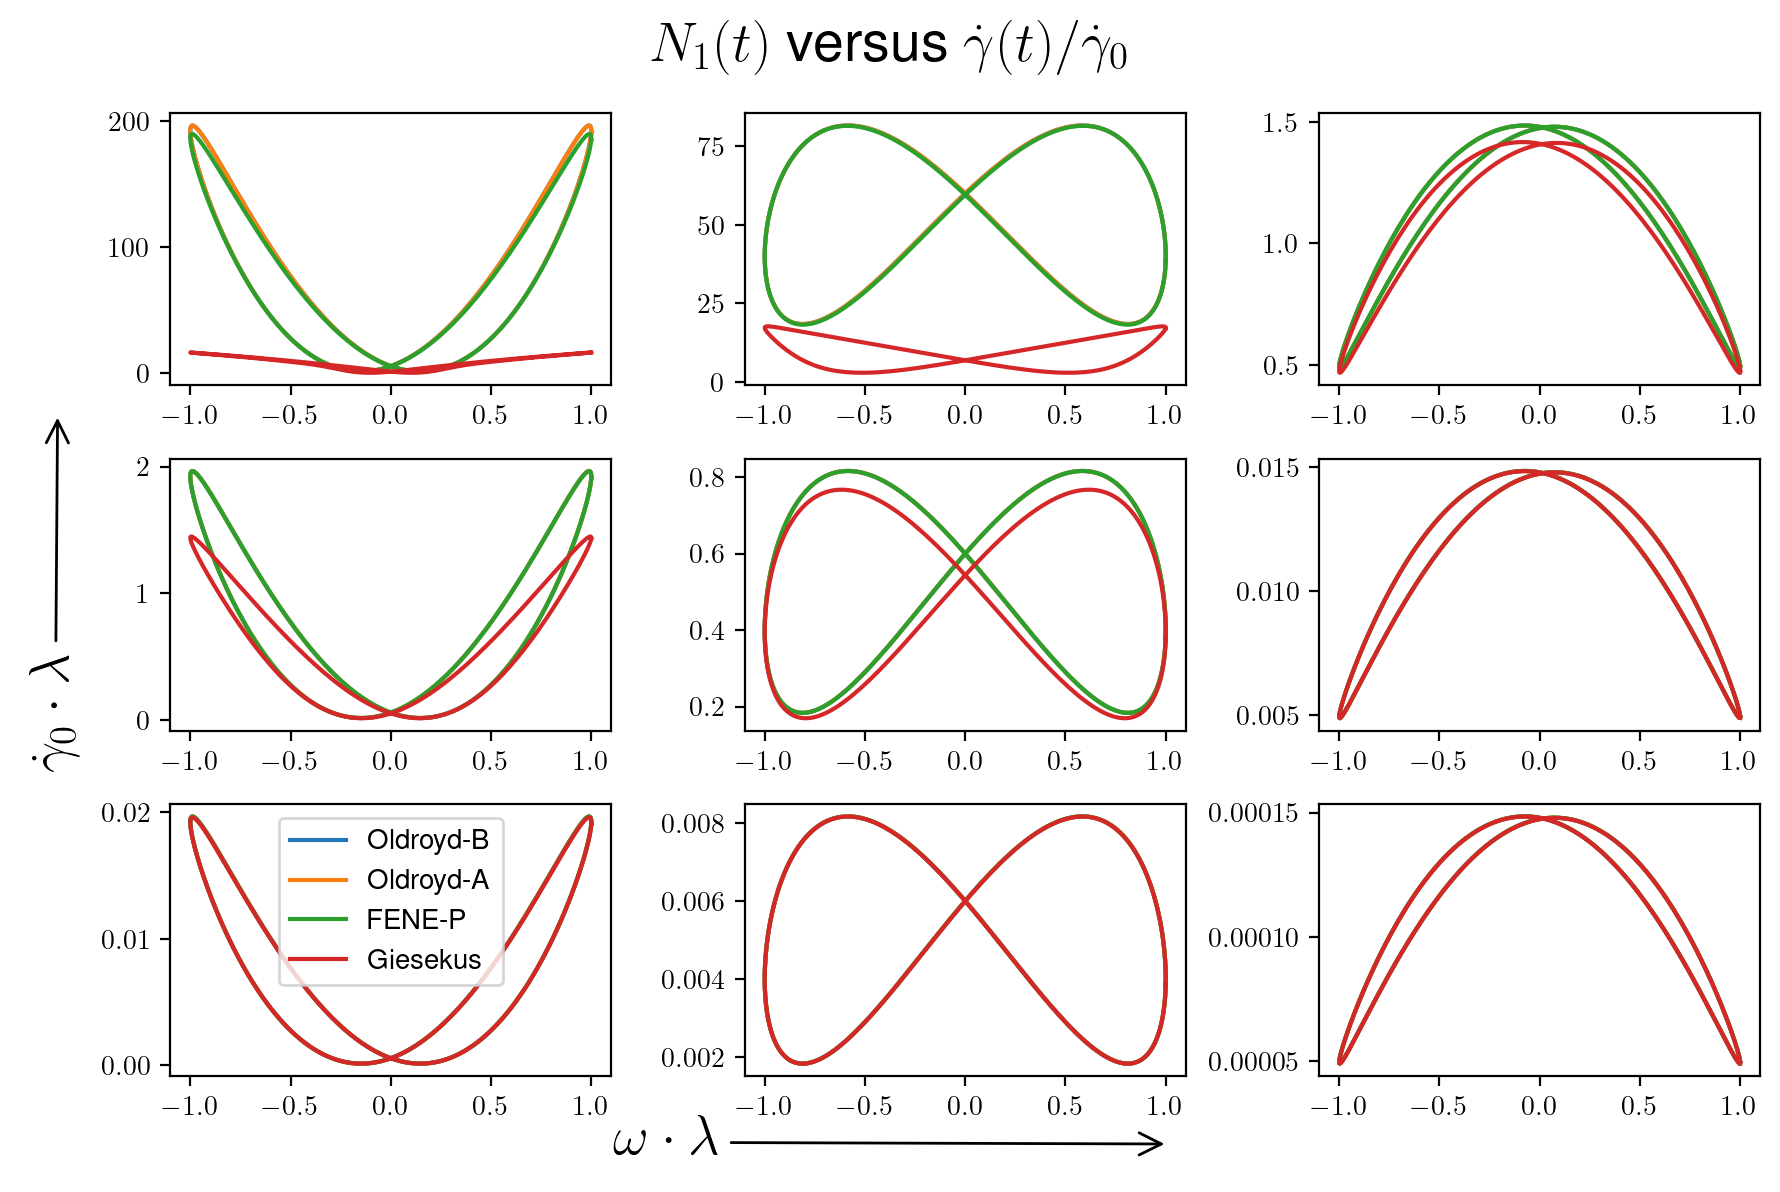

In [15]:
fig, axes = plt.subplots(len(Wis), len(Des), figsize=(3*len(Des),2*len(Wis)))
for jdx, Wi in enumerate(Wis):
    for kdx, De in enumerate(Des):
        γ = lambda t: Wi/De*np.sin(De*t)
        dγdt = lambda t: Wi*np.cos(De*t)
        for idx, model in enumerate(models):
            t, τ = res_laos[idx][jdx][kdx]
            axes[len(Wis)-1-jdx,kdx].plot(dγdt(t[-257:]) / Wi, τ[:,0,0][-257:]-τ[:,1,1][-257:], label=model.name)

axes[-1,0].legend()
plt.suptitle("$N_1(t)$ versus $\\dot{\\gamma}(t) / \\dot{\\gamma}_0$", size=20)

plt.tight_layout()
fig.subplots_adjust(left=0.1)
fig.subplots_adjust(bottom=0.1)
plt.annotate("$\\dot{\\gamma}_0 \\cdot \\lambda$", fontsize=20,
    xy=(0.032, 0.65), xytext=(0.045, 0.35), xycoords='figure fraction',
    arrowprops=dict(arrowstyle="->"), ha='right', va='bottom', rotation=90
)
plt.annotate("$\\omega \\cdot \\lambda$", fontsize=20,
    xy=(0.65, 0.04), xytext=(0.4, 0.02), xycoords='figure fraction',
    arrowprops=dict(arrowstyle="->"), ha='right', va='bottom', rotation=0
)

plt.show()